In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector2 = inspect(engine)
columns = inspector2.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
most_recent_date = most_recent_date.date()
most_recent_date

datetime.date(2017, 8, 23)

In [11]:
one_year_ago = most_recent_date - dt.timedelta(days=365)
print(one_year_ago)


2016-08-23


In [12]:
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).all()

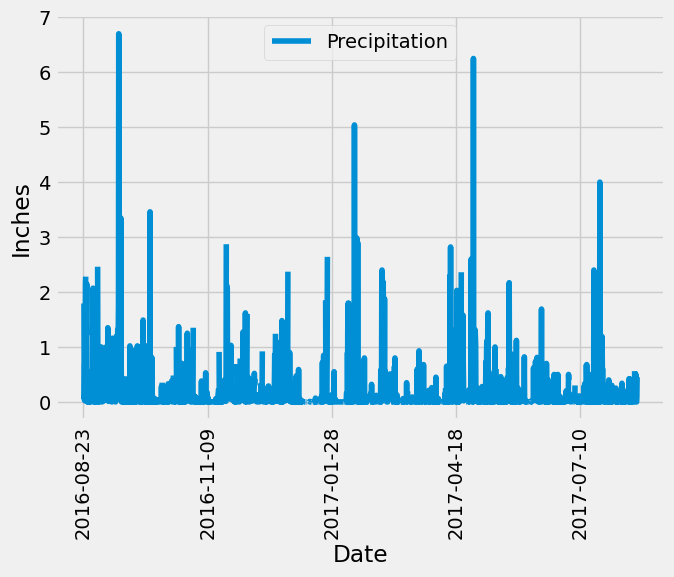

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
most_recent_date = most_recent_date.date()

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values(by='Date', inplace=True)
precipitation_df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(y='Precipitation', figsize=(7, 5))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
inspector2 = inspect(engine)
columns = inspector2.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.distinct(station.station)).count()
total_stations

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_row_counts = session.query(measurement.station, func.count()).\
    group_by(measurement.station).\
    order_by(func.count().desc()).all()
station_row_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurement.station,
      func.min(measurement.tobs),
      func.max(measurement.tobs),
      func.avg(measurement.tobs)]
most_active_station = session.query(*sel).\
    filter(measurement.station == 'USC00519281').all()
most_active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

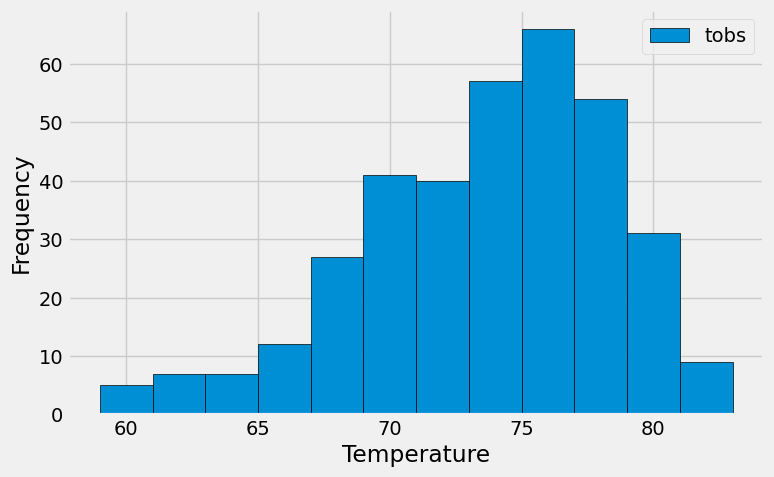

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date one year ago from the last date in data set
most_active_station_last_date = session.query(func.max(measurement.date)).\
    filter(measurement.station == 'USC00519281').scalar()

most_active_station_last_date = dt.datetime.strptime(most_active_station_last_date, '%Y-%m-%d')
one_year_ago = most_active_station_last_date - dt.timedelta(days=365)

# Query temperature observation data for the last 12 months for the most active station
temperature_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 5))
plt.hist(temperature_df['Temperature'], bins=12, edgecolor='black', label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [20]:
# Close Session
session.close()